In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [29]:
# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/Yashwanth-Kumar-G/RUL/refs/heads/main/Battery_RUL.csv")
df


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
15059,1108,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


In [17]:
# Features and target selection
features = ["Discharge Time (s)", "Decrement 3.6-3.4V (s)", "Max. Voltage Dischar. (V)", 
            "Min. Voltage Charg. (V)", "Time at 4.15V (s)", "Time constant current (s)", "Charging time (s)"]
target = "RUL"


In [19]:
# Normalize data
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df.head()  # Check normalized data


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1,0.002699,0.495801,0.475000,0.139278,0.022729,0.007663,0.012231,1112
1,2,0.007722,0.495827,0.911364,0.145910,0.022929,0.007671,0.011916,1111
2,3,0.007706,0.495753,0.913636,0.148858,0.022929,0.007671,0.011825,1110
3,4,0.007698,0.495713,0.914394,0.149595,0.022901,0.007671,0.011714,1109
4,6,0.067842,0.531435,0.944697,0.277082,0.022815,0.060414,0.064372,1107


In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)


# Baseline SVR

In [23]:
# Train SVR model without cross-validation or hyperparameter tuning
svr_model = SVR(kernel="rbf")  # Default SVR
svr_model.fit(X_train, y_train)

# Predict using SVR model
y_pred_svr = svr_model.predict(X_test)


In [25]:
# Evaluate SVR model
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2s_svr = r2_score(y_test, y_pred_svr)

print(f"SVR Model - MAE: {mae_svr}, RMSE: {rmse_svr}, R2Score: {r2s_svr}")


SVR Model - MAE: 126.19365951192538, RMSE: 167.58530408930002, R2Score: 0.728873211032474


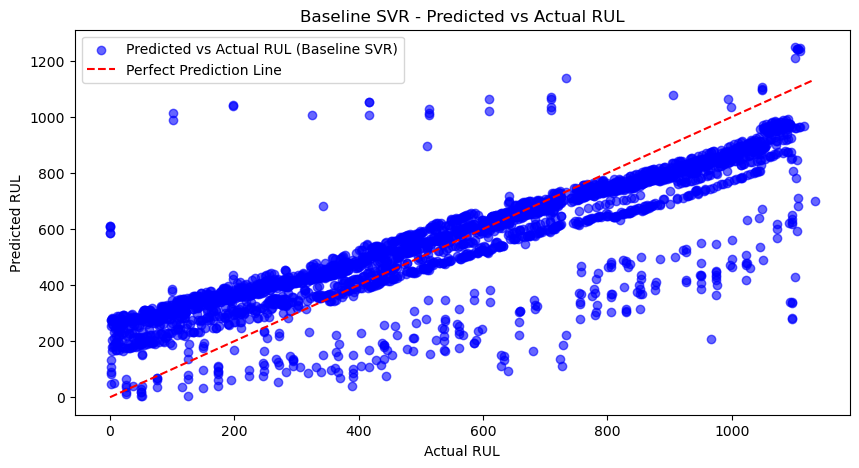

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_svr, alpha=0.6, label="Predicted vs Actual RUL (Baseline SVR)", color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Prediction Line")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Baseline SVR - Predicted vs Actual RUL")
plt.legend()
plt.show()


# Hypertuned SVR

In [38]:
# Define hyperparameter grid for SVR
param_grid = {
    "C": [0.1, 1, 10, 100],      # Regularization parameter
    "epsilon": [0.01, 0.1, 0.2], # Defines margin of tolerance
    "kernel": ["rbf", "linear"], # Kernel types
    "gamma": ["scale", "auto"]   # Kernel coefficient
}


In [44]:
# Initialize SVR model
svr = SVR()

# Perform GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_svr = grid_search.best_estimator_

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


In [46]:
# Train SVR model with best parameters
best_svr.fit(X_train, y_train)

# Predict using optimized SVR model
y_pred_svr_opt = best_svr.predict(X_test)


In [48]:
# Evaluate SVR model
mae_svr_opt = mean_absolute_error(y_test, y_pred_svr_opt)
mse_svr_opt = mean_squared_error(y_test, y_pred_svr_opt)
rmse_svr_opt = np.sqrt(mse_svr_opt)
r2s_svr_opt = r2_score(y_test, y_pred_svr_opt)

print(f"Optimized SVR Model - MAE: {mae_svr_opt}, RMSE: {rmse_svr_opt}, R2Score: {r2s_svr_opt}")


Optimized SVR Model - MAE: 65.9429619066013, RMSE: 94.33482589311942, R2Score: 0.914089811571603


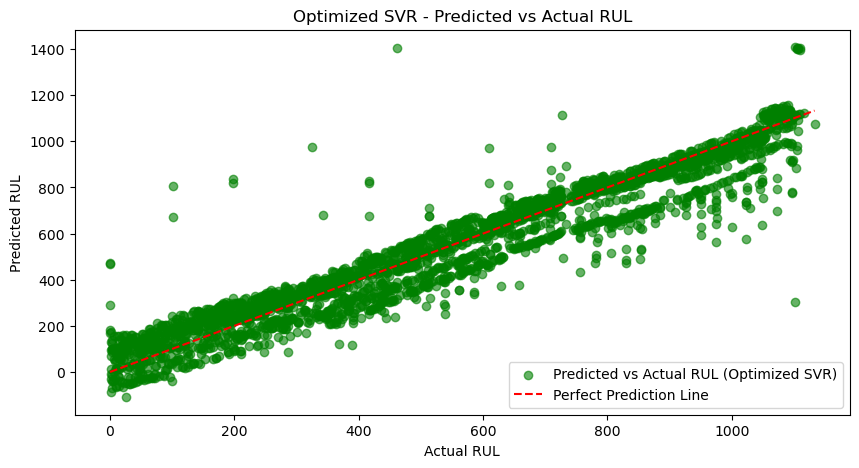

In [50]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_svr_opt, alpha=0.6, label="Predicted vs Actual RUL (Optimized SVR)", color="green")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red", label="Perfect Prediction Line")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Optimized SVR - Predicted vs Actual RUL")
plt.legend()
plt.show()


# Comparison

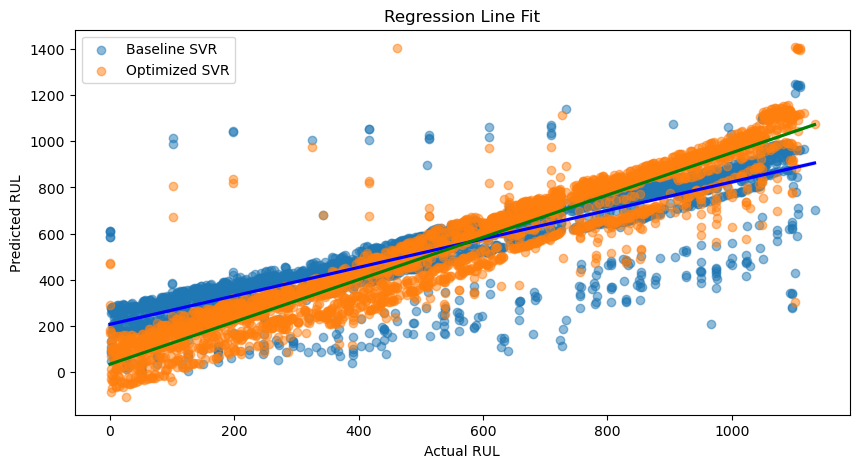

In [79]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.regplot(x=y_test, y=y_pred_svr, scatter_kws={"alpha":0.5}, line_kws={"color":"blue"}, label="Baseline SVR")
sns.regplot(x=y_test, y=y_pred_svr_opt, scatter_kws={"alpha":0.5}, line_kws={"color":"green"}, label="Optimized SVR")
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Regression Line Fit")
plt.legend()
plt.show()


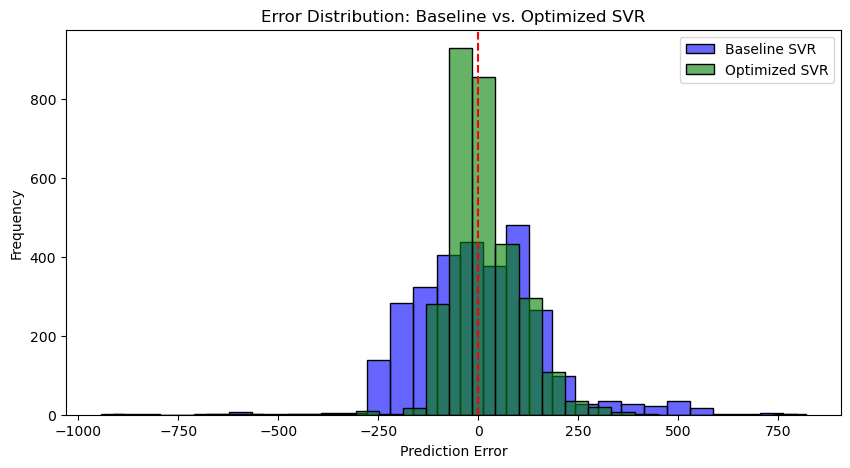

In [85]:
errors_svr = y_test - y_pred_svr
errors_svr_opt = y_test - y_pred_svr_opt

plt.figure(figsize=(10, 5))
sns.histplot(errors_svr, bins=30, color="blue", alpha=0.6, label="Baseline SVR")
sns.histplot(errors_svr_opt, bins=30, color="green", alpha=0.6, label="Optimized SVR")
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution: Baseline vs. Optimized SVR")
plt.legend()
plt.show()


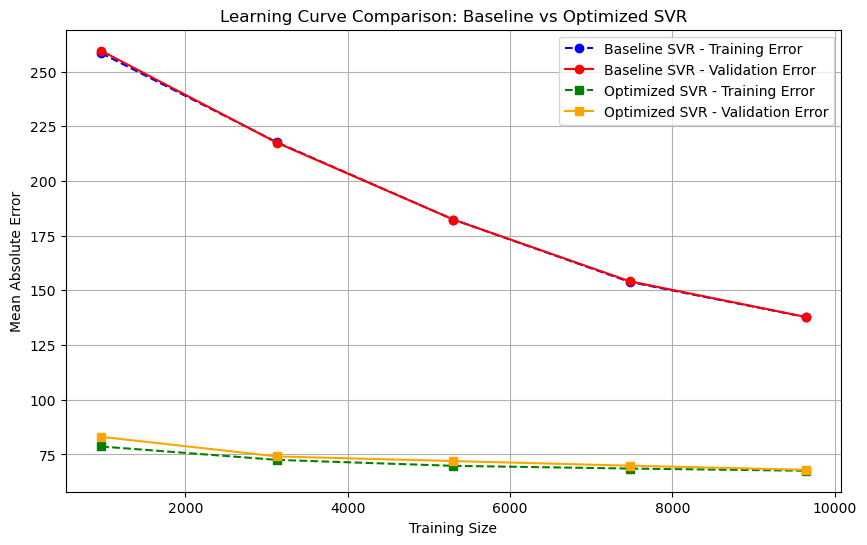

In [95]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR

# Define baseline SVR model
baseline_svr = SVR()

# Retrieve best hyperparameters from GridSearchCV
best_params = grid_search.best_params_  # Ensure this step is executed before using it

# Define optimized SVR model with best hyperparameters
optimized_svr = SVR(C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"])

# Get learning curve data for Baseline SVR
train_sizes, train_scores, test_scores = learning_curve(
    baseline_svr, X_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

# Get learning curve data for Optimized SVR
train_sizes_opt, train_scores_opt, test_scores_opt = learning_curve(
    optimized_svr, X_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)
train_mean_opt = -np.mean(train_scores_opt, axis=1)
test_mean_opt = -np.mean(test_scores_opt, axis=1)

# Plot combined learning curve
plt.figure(figsize=(10, 6))

# Baseline SVR
plt.plot(train_sizes, train_mean, label="Baseline SVR - Training Error", marker="o", color="blue", linestyle="dashed")
plt.plot(train_sizes, test_mean, label="Baseline SVR - Validation Error", marker="o", color="red")

# Optimized SVR
plt.plot(train_sizes_opt, train_mean_opt, label="Optimized SVR - Training Error", marker="s", color="green", linestyle="dashed")
plt.plot(train_sizes_opt, test_mean_opt, label="Optimized SVR - Validation Error", marker="s", color="orange")

# Labels and Title
plt.xlabel("Training Size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve Comparison: Baseline vs Optimized SVR")
plt.legend()
plt.grid()
plt.show()
